In [1]:
"""
# Raster Tile Mosaicing — Cloudless Mosaic

**Objective:** Merge multiple georeferenced satellite raster tiles into a single seamless, cloudless mosaic.

**Workflow:**
1. Install libraries & download dataset
2. List and validate input tiles
3. Preview individual tile
4. Reproject and resample tiles
5. Merge tiles to mosaic
6. Validate mosaic
7. Visualize mosaic (downsampled + zoom)
8. Save outputs (GeoTIFF, PNG, CSV, TXT report)
"""


#install required libraries
!apt-get update -y && apt-get install -y gdal-bin libgdal-dev
# Python packages
!pip install --quiet rasterio rioxarray geopandas matplotlib pillow numpy rasterstats tqdm

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://cli.github.com/packages stable/main amd64 Packages [343 B]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,145 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy

In [2]:
# download & unzip dataset
import os
DATA_URL = "https://objectstore.e2enetworks.net/btechtasksampledata/data.zip"
WORKDIR = "/content/raster_mosaic_task"
os.makedirs(WORKDIR, exist_ok=True)

zip_path = os.path.join(WORKDIR, "data.zip")
print("Downloading dataset — this may take a minute...")
# Use wget to download (Colab environment)
!wget -q --show-progress -O "{zip_path}" "{DATA_URL}"

print("Unzipping...")
!unzip -o "{zip_path}" -d "{WORKDIR}" > /dev/null
print("Unzip complete. Files are in", WORKDIR)


/content/raster_mos 100%[===================>]   1.31G  15.1MB/s    in 90s     
Unzipping...
Unzip complete. Files are in /content/raster_mosaic_task


In [3]:
#  list GeoTIFFs and count them
from glob import glob
tiff_paths = sorted(glob(os.path.join(WORKDIR, "**", "*.tif"), recursive=True) +
                    glob(os.path.join(WORKDIR, "**", "*.tiff"), recursive=True))
print(f"Found {len(tiff_paths)} GeoTIFF(s). Sample files:")
for p in tiff_paths[:20]:
    print(" -", p)
if len(tiff_paths) == 0:
    print("WARNING: No .tif files found. Check that the dataset unzipped correctly and path is right.")


Found 10 GeoTIFF(s). Sample files:
 - /content/raster_mosaic_task/data/17_20241129_054359_147_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
 - /content/raster_mosaic_task/data/18_20241129_054358_499_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
 - /content/raster_mosaic_task/data/19_20241129_054357_865_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
 - /content/raster_mosaic_task/data/32_20240716_043003_536_SN32_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
 - /content/raster_mosaic_task/data/33_20240716_043002_901_SN32_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
 - /content/raster_mosaic_task/data/34_20240716_043002_264_SN32_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
 - /content/raster_mosaic_task/data/4_20241124_054616_030_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
 - /content/raster_mosaic_task/data/5_20241124_054615_396_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
 - /content/raster_mosaic_task/data/6_20241124_054614_762_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
 - /content/raster_mosaic_task/data/7_202

In [4]:
#print metadata for each tile (CRS, transform, resolution, bounds, dtype, nodata)
import rasterio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform

def print_meta(path):
    with rasterio.open(path) as src:
        print(f"\nFile: {os.path.basename(path)}")
        print("  CRS:", src.crs)
        print("  Width x Height:", src.width, "x", src.height)
        res = src.transform[0], -src.transform[4]
        print("  Pixel Size (x, y):", res)
        print("  Bounds:", src.bounds)
        print("  Count (bands):", src.count)
        print("  Dtype:", src.dtypes[0])
        print("  Nodatas:", src.nodatavals)
        # quick check if all tiles have same res & crs should be visible here

for p in tiff_paths[:10]:
    print_meta(p)



File: 17_20241129_054359_147_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
  CRS: EPSG:3857
  Width x Height: 10927 x 11977
  Pixel Size (x, y): (0.9356054896919204, 0.9356054896918405)
  Bounds: BoundingBox(left=8734619.555673013, bottom=3531268.269493429, right=8744842.916858876, top=3542474.016443468)
  Count (bands): 4
  Dtype: uint8
  Nodatas: (None, None, None, None)

File: 18_20241129_054358_499_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
  CRS: EPSG:3857
  Width x Height: 10862 x 11655
  Pixel Size (x, y): (0.9492307103382531, 0.9492307103382034)
  Bounds: BoundingBox(left=8730333.821547678, bottom=3534587.482422642, right=8740644.365523372, top=3545650.7663516337)
  Count (bands): 4
  Dtype: uint8
  Nodatas: (None, None, None, None)

File: 19_20241129_054357_865_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
  CRS: EPSG:3857
  Width x Height: 10877 x 11629
  Pixel Size (x, y): (0.9413985629369338, 0.9413985629369082)
  Bounds: BoundingBox(left=8726150.181506908, bottom=3537796.375

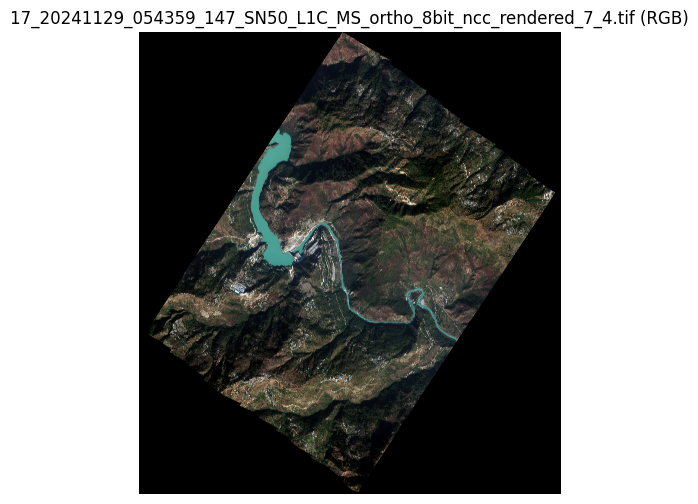

In [5]:
#quick thumbnail of first tile (band 1 or RGB if present)
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

if tiff_paths:
    p = tiff_paths[0]
    with rasterio.open(p) as src:
        # If 3 bands or more, display RGB; else single band.
        arr = src.read()
        if arr.shape[0] >= 3:
            # basic RGB display: use bands 1,2,3
            img = np.dstack([arr[0], arr[1], arr[2]])
            # scale for visualization (stretch)
            def scale(a):
                a = a.astype('float32')
                a = (a - a.min()) / max(1e-6, (a.max()-a.min()))
                return a
            img = np.dstack([scale(img[:,:,0]), scale(img[:,:,1]), scale(img[:,:,2])])
            plt.figure(figsize=(6,6))
            plt.imshow(img)
            plt.title(os.path.basename(p) + " (RGB)")
            plt.axis('off')
        else:
            plt.figure(figsize=(6,6))
            show(src.read(1), title=os.path.basename(p))
else:
    print("No tiff files to preview.")


In [6]:
import os
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from tqdm import tqdm

BASE_DIR = "/content/raster_mosaic_task"
INPUT_DIR = BASE_DIR
OUTPUT_DIR = os.path.join(BASE_DIR, "standardized_tiles")

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Target CRS and Pixel Size
TARGET_CRS = "EPSG:3857"
TARGET_RES = 1.21   # meter/pixel (chosen based on metadata)

print("Output directory:", OUTPUT_DIR)
print("Target CRS:", TARGET_CRS, "| Target resolution:", TARGET_RES)


Output directory: /content/raster_mosaic_task/standardized_tiles
Target CRS: EPSG:3857 | Target resolution: 1.21


In [7]:
from glob import glob

tiff_files = sorted(
    glob(os.path.join(INPUT_DIR, "**", "*.tif"), recursive=True) +
    glob(os.path.join(INPUT_DIR, "**", "*.tiff"), recursive=True)
)

print(f"Found {len(tiff_files)} input tiles.")
tiff_files[:5]


Found 10 input tiles.


['/content/raster_mosaic_task/data/17_20241129_054359_147_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif',
 '/content/raster_mosaic_task/data/18_20241129_054358_499_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif',
 '/content/raster_mosaic_task/data/19_20241129_054357_865_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif',
 '/content/raster_mosaic_task/data/32_20240716_043003_536_SN32_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif',
 '/content/raster_mosaic_task/data/33_20240716_043002_901_SN32_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif']

In [8]:
def standardize_tile(input_path, output_path, target_crs, target_res):
    with rasterio.open(input_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height,
            *src.bounds,
            resolution=target_res
        )

        kwargs = src.meta.copy()
        kwargs.update({
            "crs": target_crs,
            "transform": transform,
            "width": width,
            "height": height,
            "dtype": "uint8"
        })

        with rasterio.open(output_path, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.bilinear  # good for imagery
                )


In [9]:
standardized_paths = []

print("Reprojecting + Resampling tiles...\n")

for path in tqdm(tiff_files):
    filename = os.path.basename(path)
    output_path = os.path.join(OUTPUT_DIR, filename)

    standardize_tile(
        input_path=path,
        output_path=output_path,
        target_crs=TARGET_CRS,
        target_res=TARGET_RES
    )

    standardized_paths.append(output_path)

print("\nStandardization complete!")
print("Standardized tiles saved to:", OUTPUT_DIR)


Reprojecting + Resampling tiles...



100%|██████████| 10/10 [05:16<00:00, 31.62s/it]


Standardization complete!
Standardized tiles saved to: /content/raster_mosaic_task/standardized_tiles


In [10]:
import rasterio

print("Checking standardized metadata:")

for p in standardized_paths[:5]:
    with rasterio.open(p) as src:
        print("\nFile:", os.path.basename(p))
        print("  CRS:", src.crs)
        print("  Resolution:", src.res)
        print("  Size:", src.width, "x", src.height)
        print("  Bands:", src.count)


Checking standardized metadata:

File: 17_20241129_054359_147_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
  CRS: EPSG:3857
  Resolution: (1.21, 1.21)
  Size: 8450 x 9261
  Bands: 4

File: 18_20241129_054358_499_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
  CRS: EPSG:3857
  Resolution: (1.21, 1.21)
  Size: 8522 x 9144
  Bands: 4

File: 19_20241129_054357_865_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
  CRS: EPSG:3857
  Resolution: (1.21, 1.21)
  Size: 8463 x 9048
  Bands: 4

File: 32_20240716_043003_536_SN32_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
  CRS: EPSG:3857
  Resolution: (1.21, 1.21)
  Size: 7206 x 6978
  Bands: 4

File: 33_20240716_043002_901_SN32_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
  CRS: EPSG:3857
  Resolution: (1.21, 1.21)
  Size: 7175 x 6998
  Bands: 4


In [11]:
# Python cell
import numpy as np
from scipy.ndimage import binary_opening, binary_closing
import rasterio
import os
from tqdm import tqdm

MASKED_DIR = os.path.join(WORKDIR, "cloudmasked_tiles")
os.makedirs(MASKED_DIR, exist_ok=True)

def improved_cloud_mask(rgb):
    # rgb shape (3,H,W) floats normalized 0..1
    r, g, b = rgb
    brightness = (r + g + b) / 3.0
    mx = np.maximum(np.maximum(r, g), b)
    mn = np.minimum(np.minimum(r, g), b)
    saturation = (mx - mn) / np.maximum(mx, 1e-6)
    mask = (brightness > 0.75) & (saturation < 0.25)
    mask |= (brightness > 0.92)  # very bright (thin clouds)
    mask = binary_opening(mask, structure=np.ones((3,3)))
    mask = binary_closing(mask, structure=np.ones((5,5)))
    return mask

print("Creating cloud-masked tiles...")
masked_paths = []
for p in tqdm(standardized_paths):
    with rasterio.open(p) as src:
        # if tile has <3 bands, simply copy; else compute mask on first 3 bands
        if src.count < 3:
            # just copy
            outp = os.path.join(MASKED_DIR, os.path.basename(p))
            # copy file bytes (fast)
            with rasterio.open(outp, "w", **src.meta) as dst:
                for i in range(1, src.count+1):
                    dst.write(src.read(i), i)
            masked_paths.append(outp)
            continue

        arr = src.read([1,2,3]).astype('float32')
        # normalize by per-band max to 0..1 (preserve per-tile scaling)
        arr_norm = arr / np.maximum(arr.max(), 1e-6)
        mask = improved_cloud_mask(arr_norm)

        meta = src.meta.copy()
        # choose a nodata value appropriate to dtype: use src.nodata if exists, otherwise 0 for uint8 or 0 for other integer types
        nodata_val = src.nodata if src.nodata is not None else 0
        meta.update({"nodata": nodata_val, "compress":"LZW", "tiled": True})

        outp = os.path.join(MASKED_DIR, os.path.basename(p))
        with rasterio.open(outp, "w", **meta) as dst:
            for i in range(1, src.count+1):
                band = src.read(i).astype(src.dtypes[0])
                # set nodata on masked pixels
                # be careful to use dtype-compatible nodata:
                band_masked = band.copy()
                band_masked[mask] = nodata_val
                dst.write(band_masked, i)

        masked_paths.append(outp)

print("Cloud-masked tiles created:", len(masked_paths))


Creating cloud-masked tiles...


100%|██████████| 10/10 [02:41<00:00, 16.11s/it]

Cloud-masked tiles created: 10


In [12]:
# Python cell - streaming merge using GDAL VRT + gdal_translate
import subprocess, shlex

tile_txt = os.path.join(MASKED_DIR, "tiles_list.txt")
with open(tile_txt, "w") as f:
    for p in sorted(masked_paths):
        f.write(p + "\n")

vrt_path = os.path.join(WORKDIR, "cloudless_mosaic.vrt")
mosaic_tif = os.path.join(WORKDIR, "cloudless_mosaic.tif")

# Build VRT (handles overlaps). Optionally set -resolution user -tr <x> <y> to force resolution.
cmd_vrt = f"gdalbuildvrt -input_file_list {shlex.quote(tile_txt)} {shlex.quote(vrt_path)}"
print("Running:", cmd_vrt)
subprocess.check_call(shlex.split(cmd_vrt))

# Translate VRT to compressed, tiled GeoTIFF on disk (streamed)
# -a_nodata sets nodata (0 used here as default; change to appropriate nodata if needed)
cmd_translate = (
    f"gdal_translate -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER "
    f"-a_nodata 0 {shlex.quote(vrt_path)} {shlex.quote(mosaic_tif)}"
)
print("Running:", cmd_translate)
subprocess.check_call(shlex.split(cmd_translate))

print("Mosaic written to:", mosaic_tif)


Running: gdalbuildvrt -input_file_list /content/raster_mosaic_task/cloudmasked_tiles/tiles_list.txt /content/raster_mosaic_task/cloudless_mosaic.vrt
Running: gdal_translate -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER -a_nodata 0 /content/raster_mosaic_task/cloudless_mosaic.vrt /content/raster_mosaic_task/cloudless_mosaic.tif
Mosaic written to: /content/raster_mosaic_task/cloudless_mosaic.tif


In [13]:
# Python cell: create a downsampled preview PNG and an 8-bit preview GeoTIFF if you need 8-bit
import numpy as np
import rasterio
from rasterio.enums import Resampling
from PIL import Image

def percentile_stretch_to_uint8(arr, lower=2, upper=98):
    """
    arr: numpy array HxW (single band) in original dtype
    returns uint8 array scaled 0..255 using lower/upper percentiles
    """
    lo = np.percentile(arr, lower)
    hi = np.percentile(arr, upper)
    clipped = np.clip(arr, lo, hi)
    scaled = ((clipped - lo) / max(1e-6, hi - lo) * 255.0).astype(np.uint8)
    return scaled

preview_png = os.path.join(WORKDIR, "cloudless_mosaic_preview.png")
preview_tif_8bit = os.path.join(WORKDIR, "cloudless_mosaic_8bit.tif")

with rasterio.open(mosaic_tif) as src:
    # read and downsample to at most 1200x1200 for preview
    max_side = 1200
    scale = min(1.0, max_side / max(src.width, src.height))
    out_width = int(src.width * scale)
    out_height = int(src.height * scale)
    rgb = src.read([1,2,3], out_shape=(3, out_height, out_width), resampling=Resampling.bilinear)
    # Convert to HxWx3 with stretch per-band
    rgb_uint8 = np.dstack([percentile_stretch_to_uint8(rgb[i]) for i in range(3)])
    # Save PNG preview
    Image.fromarray(rgb_uint8).save(preview_png)
    print("Saved PNG preview:", preview_png)

Saved PNG preview: /content/raster_mosaic_task/cloudless_mosaic_preview.png


In [14]:
# Python cell
import csv
import numpy as np
import rasterio

# Tiles metadata CSV
metadata_csv = os.path.join(WORKDIR, "tiles_metadata.csv")
with open(metadata_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Tile_Name","CRS","Width","Height","Pixel_Size_X","Pixel_Size_Y","Bands","Dtype","Nodata"])
    for p in standardized_paths:
        with rasterio.open(p) as src:
            writer.writerow([
                os.path.basename(p),
                src.crs.to_string() if src.crs else None,
                src.width,
                src.height,
                src.res[0],
                src.res[1],
                src.count,
                src.dtypes[0],
                src.nodatavals
            ])
print("Tile metadata saved to:", metadata_csv)

# Basic mosaic validation
report_path = os.path.join(WORKDIR, "mosaic_report.txt")
with rasterio.open(mosaic_tif) as src:
    data = src.read()
    nodata = src.nodata
    if nodata is not None:
        nodata_mask = np.any(data == nodata, axis=0)
    else:
        nodata_mask = np.zeros((src.height, src.width), dtype=bool)
    num_nodata = int(nodata_mask.sum())

    with open(report_path, "w") as f:
        f.write("Mosaic Report\n")
        f.write("=============\n\n")
        f.write(f"Mosaic path: {mosaic_tif}\n")
        f.write(f"CRS: {src.crs}\n")
        f.write(f"Width x Height: {src.width} x {src.height}\n")
        f.write(f"Bounds: {src.bounds}\n")
        f.write(f"Pixel Size: {src.res}\n")
        f.write(f"Bands: {src.count}\n")
        f.write(f"Dtype: {src.dtypes[0]}\n")
        f.write(f"Nodata value: {src.nodata}\n")
        f.write(f"NoData pixels: {num_nodata}\n")

print("Mosaic report saved to:", report_path)


Tile metadata saved to: /content/raster_mosaic_task/tiles_metadata.csv
Mosaic report saved to: /content/raster_mosaic_task/mosaic_report.txt


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
